# Project 2: Implementing a Simple Convolutional Neural Network (CNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Convolutional Neural Network (CNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project!  (Note, however, that your work should not simply mirror models already covered in the course, nor published works of others.) Kaggle would be a good source to look for datasets. Below are some examples that we have already seen, which would be of an appropriate nature; you might tackle these (with your own approach), or choose a different dataset:
- CIFAR-10: A dataset of 60,000 32x32 color images in 10 classes with 6,000 images per class.
- Fashion-MNIST: A dataset of 70,000 28x28 grayscale images of 10 different clothing caregories.


In [12]:
# --- Imports ---
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import kagglehub
from torchvision.datasets import ImageFolder

# For GPU check
script_dir = os.getcwd()
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
base_path = kagglehub.dataset_download("puneet6060/intel-image-classification") # Download latest version
print("Path to dataset files:", base_path)

Path to dataset files: /home/jetauto/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [21]:
train_path = f"{base_path}/seg_train/seg_train"
test_path = f"{base_path}/seg_test/seg_test"
pred_path = f"{base_path}/seg_pred/seg_pred"
output_dir = os.path.join(script_dir, "intel_predictions")
os.makedirs(output_dir, exist_ok=True)

# Define image transform (resize + convert to tensor)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # CNN input size
    transforms.ToTensor()
])

# Load datasets using PyTorch ImageFolder
train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset  = ImageFolder(root=test_path, transform=transform)

# Prepare DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Confirm dataset loaded
print("✅ Loaded Intel Dataset")
class_names = train_dataset.classes
print("Classes:", class_names)
print("Train size:", len(train_dataset), " | Test size:", len(test_dataset))

✅ Loaded Intel Dataset
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train size: 14034  | Test size: 3000


In [15]:
# Convert PyTorch ImageFolder dataset to NumPy arrays (HWC format for TensorFlow)
def convert_to_numpy(dataset):
    images, labels = [], []
    for img, label in dataset:
        img = img.permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Convert both train and test datasets to NumPy
X_train_np, y_train_np = convert_to_numpy(train_dataset)
X_test_np, y_test_np   = convert_to_numpy(test_dataset)

# Split training data into train and validation sets (80% / 20%)
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.2, stratify=y_train_np, random_state=42
)

In [16]:
# --- Data Augmentation (only for training data) ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

# --- Normalization Layer ---
normalizer = tf.keras.layers.Rescaling(1./255, name="rescale")

# --- Training dataset ---
train_ds = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))  # Apply augmentation
train_ds = train_ds.map(lambda x, y: (normalizer(x), y))         # Normalize
train_ds = train_ds.shuffle(len(X_train_np)).batch(64).cache().prefetch(tf.data.AUTOTUNE)

# --- Validation dataset ---
val_ds = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np))
val_ds = val_ds.map(lambda x, y: (normalizer(x), y)).batch(64).cache().prefetch(tf.data.AUTOTUNE)

# --- Test dataset ---
test_ds = tf.data.Dataset.from_tensor_slices((X_test_np, y_test_np))
test_ds = test_ds.map(lambda x, y: (normalizer(x), y)).batch(64).cache().prefetch(tf.data.AUTOTUNE)

# Optional: Check shape of one example
for img, label in train_ds.take(1):
    print("✅ Image shape:", img.shape, "| Label:", label.numpy())

2025-06-17 18:49:01.354646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 10286 of 11227


✅ Image shape: (64, 64, 64, 3) | Label: [0 1 5 5 3 3 2 2 1 4 1 5 3 2 3 0 4 2 0 1 4 0 5 0 5 2 2 5 3 4 1 0 0 2 3 4 2
 1 5 2 1 1 4 1 0 3 4 3 3 5 1 5 4 2 0 3 2 1 3 3 0 5 4 5]


2025-06-17 18:49:02.194108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2025-06-17 18:49:02.194865: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
model = tf.keras.Sequential([
    layers.Input(shape=(64, 64, 3)),

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), name="conv1"),
    layers.BatchNormalization(name="bn1"),
    layers.MaxPooling2D(name="pool1"),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), name="conv2"),
    layers.BatchNormalization(name="bn2"),
    layers.MaxPooling2D(name="pool2"),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), name="conv3"),
    layers.BatchNormalization(name="bn3"),
    layers.MaxPooling2D(name="pool3"),

    # Conv Block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name="conv4"),
    layers.BatchNormalization(name="bn4"),
    layers.MaxPooling2D(name="pool4"),

    # Classification Head
    layers.Flatten(name="flatten"),
    layers.Dense(256, activation='relu', name="fc1"),
    layers.Dropout(0.5, name="dropout1"),
    layers.Dense(128, activation='relu', name="fc2"),
    layers.Dropout(0.3, name="dropout2"),
    layers.Dense(6, activation='softmax', name="output")
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Visualize model architecture
model.summary() # tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 32)        896       
                                                                 
 bn1 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 64)        18496     
                                                                 
 bn2 (BatchNormalization)    (None, 32, 32, 64)        256       
                                                                 
 pool2 (MaxPooling2D)        (None, 1

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback: Reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# Callback: Stop training early if no improvement in validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


2025-06-17 18:49:13.828136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 10896 of 11227
2025-06-17 18:49:14.140920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


176/176 [==============================] - 15s 15ms/step - loss: 1.5165 - accuracy: 0.4642 - val_loss: 6.0343 - val_accuracy: 0.1617 - lr: 0.0010
Epoch 2/50
176/176 [==============================] - 2s 14ms/step - loss: 1.1613 - accuracy: 0.5710 - val_loss: 2.3372 - val_accuracy: 0.1617 - lr: 0.0010
Epoch 3/50
176/176 [==============================] - 2s 14ms/step - loss: 1.0277 - accuracy: 0.6273 - val_loss: 3.6068 - val_accuracy: 0.1881 - lr: 0.0010
Epoch 4/50
176/176 [==============================] - 2s 14ms/step - loss: 0.9189 - accuracy: 0.6742 - val_loss: 0.9192 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 5/50
176/176 [==============================] - 3s 15ms/step - loss: 0.8442 - accuracy: 0.6968 - val_loss: 1.0213 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 6/50
176/176 [==============================] - 3s 15ms/step - loss: 0.7728 - accuracy: 0.7298 - val_loss: 2.1815 - val_accuracy: 0.1575 - lr: 0.0010
Epoch 7/50
173/176 [============================>.] - ETA: 0s - loss: 0.72

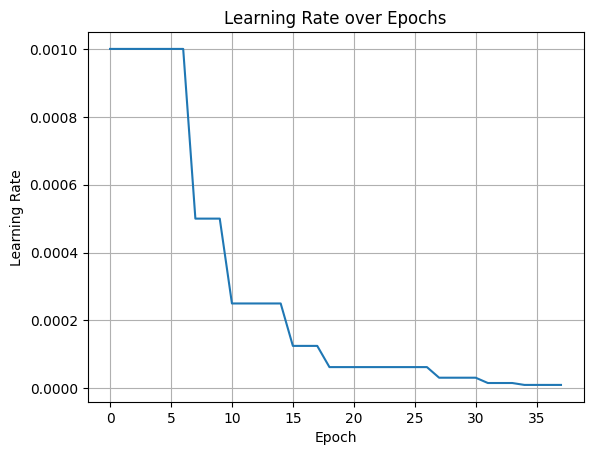

✅ Final Test Accuracy: 79.93%


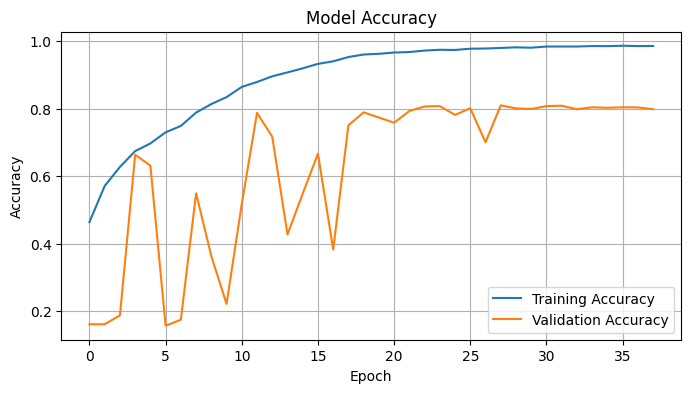

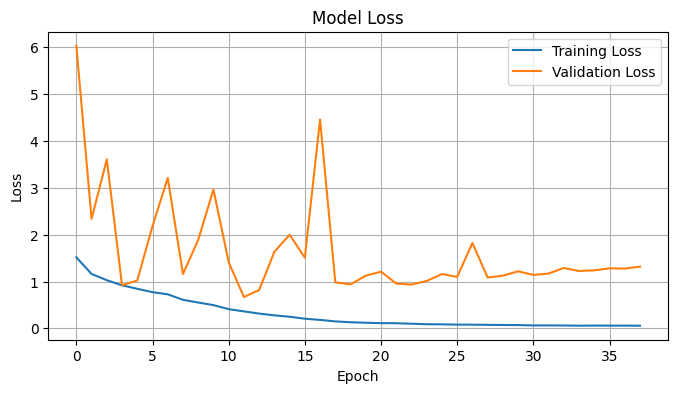

In [19]:
# --- Learning Rate History ---
lrs = history.history.get("lr")
if lrs:
    plt.plot(lrs)
    plt.title("Learning Rate over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.grid(True)
    plt.show()

# --- Final Test Evaluation ---
loss, acc = model.evaluate(test_ds, verbose=0)
print(f"✅ Final Test Accuracy: {acc * 100:.2f}%")

# --- Accuracy Plot ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Loss Plot ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import shutil
from PIL import Image
# Create subfolders for each class
for class_name in class_names:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

# Define transform for input images
img_size = (64, 64)

def preprocess_image(path):
    img = Image.open(path).convert("RGB").resize(img_size)
    img_array = np.array(img) / 255.0  # normalize
    return np.expand_dims(img_array, axis=0)  # shape: (1, 64, 64, 3)

# Predict and move files
# predicted_counts = {}
for filename in os.listdir(pred_path):
    file_path = os.path.join(pred_path, filename)

    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue  # skip non-image files

    img = preprocess_image(file_path)
    pred = model.predict(img, verbose=0)
    pred_class_index = np.argmax(pred)
    pred_class = class_names[pred_class_index]

    # # Count per class
    # predicted_counts[pred_class] = predicted_counts.get(pred_class, 0) + 1

    # Move file to class-labeled folder
    dest_path = os.path.join(output_dir, pred_class, filename)
    shutil.copy(file_path, dest_path)

print("✅ Predictions saved to:", output_dir)

✅ Predictions saved to: /home/jetauto/Desktop/Seneca_Class_Notes/Semester 2/AIG220 - Deep Learning/Project 2/intel_predictions
📦 Predicted image distribution: {'buildings': 6842, 'street': 392, 'forest': 66, 'mountain': 1}


---
### Questions
Answer the following questions in detail.

1. What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.
2. Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?
3. What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?
4. Why are activation functions important in CNNs? Compare the use of ReLU (Rectified Linear Unit) with other activation functions.
5. Describe the process of training a CNN. What are some common challenges faced during training?
6. What are some common evaluation metrics used to assess the performance of a CNN on a classification task?
7. How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.